# A3 : Model comparison for satellite imagery with TorchGeo

This Jupyter Notebook allows you to:
- Upload your own satellite imagery
- Compare two different pre-trained models side-by-side
- Visualize results with detailed performance metrics

Built with [TorchGeo](https://github.com/microsoft/torchgeo), to get pre-trained models for satellite imagery.

In [32]:
# Install necessary libraries (uncomment and run if not already installed)
%pip install torch torchvision
%pip install rasterio pillow numpy pytorch-lightning torchgeo matplotlib seaborn pandas scikit-learn ipywidgets

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


## Import Libraries and Setup

This first cell installs the required libraries for the notebook.

In [33]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.transforms import Compose, Normalize, ToTensor
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import ipywidgets as widgets
from IPython.display import display, clear_output
from io import BytesIO

# TorchGeo imports
try:
    import torchgeo
    print(f"TorchGeo version: {torchgeo.__version__}")
except ImportError:
    print("Please install torchgeo: pip install torchgeo")
    raise

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")



TorchGeo version: 0.7.0
Using device: cuda


## Configuration and Model Selection

I have set up the configuration for the notebook, including the model names. You can change the model names to compare different pre-trained models but make sure they are compatible with your image data.

As a starting point, I have included two models: `resnet18` and `resnet50`. You can replace these with any other [models available in TorchGeo](https://torchgeo.readthedocs.io/en/stable/api/models.html#). Make sure to also update the [pre-trained weights](https://torchgeo.readthedocs.io/en/stable/api/models.html#pretrained-weights) if you choose different models.

In [34]:
# Available pre-trained models for comparison
available_models = {
    'ResNet-18': 'resnet18',
    'ResNet-50': 'resnet50',
}

available_sensors = {
    'Sentinel-2' : 'sentinel2'
}

loaded_models = {}
image = None
image_tensor = None

In [35]:
def load_models(output_area, selected_models):
    """Load selected models

    Args:
        output_area (widgets.Output): Output area for displaying messages
        selected_models (list): List of selected model names

    Returns:
        dict: Dictionary of loaded models
    """
    global loaded_models
        
    with output_area:
        clear_output(wait=True)
        print("Loading models...")
                        
        loaded_models = {}
            
        for model_name in selected_models:
            try:
                print(f"Loading {model_name}...")
                    
                # Get model architecture
                arch_name = available_models[model_name]
                    
                # Try to load with pretrained weights
                if 'resnet' in arch_name:
                    from torchgeo.models import resnet18, resnet50
                    from torchgeo.models import ResNet18_Weights,  ResNet50_Weights
                    if arch_name == 'resnet18':
                        weights = ResNet18_Weights.SENTINEL2_RGB_MOCO
                        model = resnet18(weights)
                    else :
                        weights = ResNet50_Weights.SENTINEL2_RGB_MOCO
                        model = resnet50(weights)
                else:
                    print(f"Model {model_name} not implemented, skipping...")
                    continue
                    
                model.eval()
                model.to(device)
                loaded_models[model_name] = model
                print(f"{model_name} loaded successfully")
                    
            except Exception as e:
                print(f"Error loading {model_name}: {str(e)}")
            
        if loaded_models:
            print(f"Successfully loaded {len(loaded_models)}")
            loaded_models = loaded_models
            return loaded_models
        else:
            print("No models loaded successfully")
            return {}            

## Pre-processing
A function to preprocess the uploaded image is defined. This function resizes the image to the input size required by the model and normalizes it using the mean and standard deviation values specific to the model.

In [36]:
def preprocess_image(image):
    """Preprocess image for model inference

    Args:
        image (PIL.Image): The image to preprocess

    Returns:
        torch.Tensor: The preprocessed image tensor
    """
    if image is None:
        return
        
    # Standard ImageNet preprocessing
    transform = Compose([
        transforms.Resize((224, 224)),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
        
    return transform(image).unsqueeze(0).to(device)
    
def display_image(image, title="Current Image for Inference"):
    """Display an image

    Args:
        image (PIL.Image): The image to display
        title (str, optional): Title for the displayed image. Defaults to "Current Image for Inference".
    """
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.imshow(image)
    ax.set_title(title)
    ax.axis('off')
    plt.tight_layout()
    plt.show()
            
def handle_uploaded_image(uploaded_file, output_area):
    """Handle upload of a custom image

    Args:
        uploaded_file (dict): The uploaded file information
        output_area (widgets.Output): Output area for displaying messages

    Returns:
        bool: True if the image was processed successfully, False otherwise
    """
    global current_image, image_tensor
    
    with output_area:
        clear_output(wait=True)
        print("Processing uploaded image...")
        
        try:
            # Process the uploaded file
            image = Image.open(BytesIO(uploaded_file['content'])).convert('RGB')
            current_image = image
            image_tensor = preprocess_image(image)
            display_image(image)
            print("Image uploaded and processed successfully!")
            return True
            
        except Exception as e:
            print(f"Error processing uploaded image: {str(e)}")
            return False
    

In [37]:
def run_inference(loaded_models, image_tensor, results_area):
    """Run inference on all loaded models

    Args:
        loaded_models (dict): Dictionary of loaded models
        image_tensor (torch.Tensor): Preprocessed image tensor
        results_area (widgets.Output): Output area for displaying results

    Returns:
        dict: Dictionary containing the inference results
    """
    if not loaded_models or image_tensor is None:
        with results_area:
            print("Please load models and an image first!")
        return None
    
    with results_area:
        clear_output(wait=True)
        print("Running inference on selected models...")
        
        results = {}
        
        # Run inference on each model
        with torch.no_grad():
            for model_name, model in loaded_models.items():
                try:
                    print(f"Running {model_name}...")
                    
                    # Forward pass
                    outputs = model(image_tensor)
                    
                    # Get probabilities
                    probabilities = F.softmax(outputs, dim=1)
                    top_probs, top_indices = torch.topk(probabilities, 5)
                    
                    results[model_name] = {
                        'probabilities': top_probs.cpu().numpy()[0],
                        'indices': top_indices.cpu().numpy()[0],
                        'raw_outputs': outputs.cpu().numpy()[0]
                    }
                    
                    print(f"{model_name} completed")
                    
                except Exception as e:
                    print(f"Error with {model_name}: {str(e)}")
                    results[model_name] = None
                    
        return results

In [38]:
def display_results(results):
    """Display inference results comparison

    Args:
        results (dict): Dictionnary containing the results
    """
    
    print("Inference results comparison")
        
        # Create comparison visualization
    valid_results = {k: v for k, v in results.items() if v is not None}
        
    if not valid_results:
        print("No valid results to display")
        return
        
    # Plot comparison
    fig, axes = plt.subplots(2, len(valid_results), figsize=(5*len(valid_results), 10))
    if len(valid_results) == 1:
        axes = axes.reshape(2, 1)
        
    # Load ImageNet class names (simplified version)
    imagenet_classes = [f"Class_{i}" for i in range(1000)]  # Simplified
        
    for idx, (model_name, result) in enumerate(valid_results.items()):
            # Top predictions bar chart
        ax1 = axes[0, idx] if len(valid_results) > 1 else axes[0]
        top_probs = result['probabilities']
        top_indices = result['indices']
            
        class_names = [f"Class {i}" for i in top_indices]
            
        bars = ax1.bar(range(5), top_probs, color=plt.cm.viridis(np.linspace(0, 1, 5)))
        ax1.set_xlabel('Top 5 Classes')
        ax1.set_ylabel('Probability')
        ax1.set_title(f'{model_name}\nTop 5 Predictions')
        ax1.set_xticks(range(5))
        ax1.set_xticklabels([f"C{i}" for i in top_indices], rotation=45)
            
        # Add probability values on bars
        for bar, prob in zip(bars, top_probs):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{prob:.3f}', ha='center', va='bottom', fontsize=10)
            
        # Raw output distribution
        ax2 = axes[1, idx] if len(valid_results) > 1 else axes[1]
        raw_outputs = result['raw_outputs']
            
        # Show distribution of raw outputs (sample first 100 for clarity)
        sample_outputs = raw_outputs[:100] if len(raw_outputs) > 100 else raw_outputs
        ax2.hist(sample_outputs, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
        ax2.set_xlabel('Raw Output Value')
        ax2.set_ylabel('Frequency')
        ax2.set_title(f'{model_name}\nRaw Output Distribution')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Print detailed results
        print("\n📊 DETAILED RESULTS:")
        print("-" * 30)
        
        for model_name, result in valid_results.items():
            print(f"\n {model_name}:")
            print(f"   Top prediction: Class {result['indices'][0]} ({result['probabilities'][0]:.4f})")
            print(f"   Confidence: {result['probabilities'][0]:.1%}")
            print(f"   Top 3 classes: {', '.join([f'Class {i}' for i in result['indices'][:3]])}")
            


## Interactive Model and Dataset Selection

This section allows you to select the model and dataset interactively. You can upload your own image for comparison.

In [39]:
# Create widgets
def create_interface():
    """Create and return the interactive interface widgets

    Returns:
        dict: A dictionary containing the interface widgets
    """
    
    # Model selection dropdown
    model_selector_1 = widgets.Dropdown(
        options=list(available_models.keys()),
        value='ResNet-18',
        description='Select model 1:',
        disabled=False,
    )
    
    model_selector_2 = widgets.Dropdown(
        options=list(available_models.keys()),
        value='ResNet-50',
        description='Select model 2 :',
        disabled=False,
    )
    
    # Image upload widget
    image_uploader = widgets.FileUpload(
        accept='image/*',
        multiple=False,
        description='Upload Image'
    )
    
    # Sensor selector
    sensor_selector = widgets.Dropdown(
        options=list(available_sensors.keys()),
        value='Sentinel-2',
    )
    
    # Buttons
    load_models_btn = widgets.Button(
        description='Load Selected Models',
        button_style='primary',
        icon='download'
    )
    
    run_inference_btn = widgets.Button(
        description='Run Inference',
        button_style='success',
        icon='play',
        disabled=True
    )
    
    # Output areas
    output_area = widgets.Output()
    results_area = widgets.Output()
    
    # Event handlers
    def on_load_models_click(button):
        selected_models = [model_selector_1.value, model_selector_2.value]
        load_models(output_area, selected_models)
        if loaded_models:
            run_inference_btn.disabled = False if image_tensor is not None else True
    
    def on_run_inference_click(button):
        results = run_inference(loaded_models, image_tensor, results_area)
        display_results(results)
    
    def on_upload_change(change):
        if change['new']:
            uploaded_file = list(change['new'])[0]
            success = handle_uploaded_image(uploaded_file, output_area)
            if success and loaded_models:
                run_inference_btn.disabled = False
    
    # Attach event handlers
    load_models_btn.on_click(on_load_models_click)
    run_inference_btn.on_click(on_run_inference_click)
    image_uploader.observe(on_upload_change, names='value')
    
    return {
        'model_selector_1': model_selector_1,
        'model_selector_2': model_selector_2,
        'image_uploader': image_uploader,
        'load_models_btn': load_models_btn,
        'sensor_selector' : sensor_selector,
        'run_inference_btn': run_inference_btn,
        'output_area': output_area,
        'results_area': results_area
    }

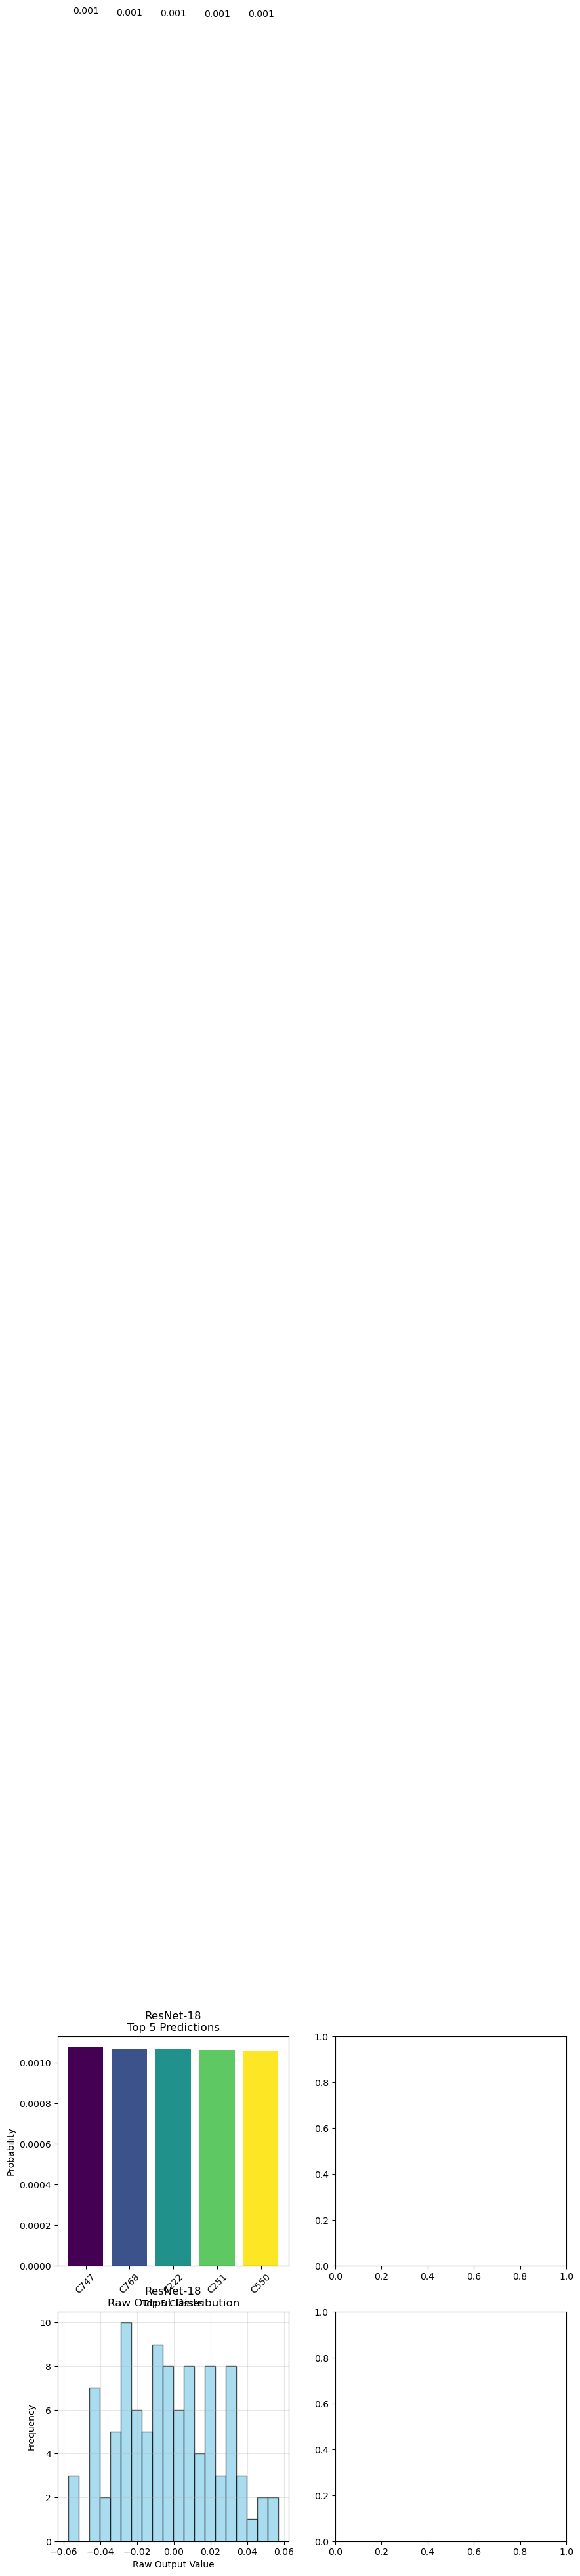

<Figure size 640x480 with 0 Axes>

In [40]:
# Create and display the interface
def display_interface():
    """Create and display the interactive interface for model comparison
    """
    widgets_dict = create_interface()
    
    # Layout the interface
    model_box = widgets.VBox([
        widgets.HTML("<h3>1. Select Models to Compare</h3>"),
        widgets_dict['model_selector_1'],
        widgets_dict['model_selector_2'],
        widgets_dict['load_models_btn']
    ])
    
    image_box = widgets.VBox([
        widgets.HTML("<h3>2. Choose Image Source</h3>"),
        widgets.HTML("<b>Upload your own image</b>"),
        widgets_dict['image_uploader'],
        widgets.HTML("<b>Select source sensor</b>"),
        widgets_dict['sensor_selector']
    ])
    
    inference_box = widgets.VBox([
        widgets.HTML("<h3>3. Run Inference</h3>"),
        widgets_dict['run_inference_btn']
    ])
    
    interface = widgets.VBox([
        model_box,
        widgets.HTML("<hr>"),
        image_box, 
        widgets.HTML("<hr>"),
        inference_box,
        widgets.HTML("<hr>"),
        widgets.HTML("<h3>Output</h3>"),
        widgets_dict['output_area'],
        widgets_dict['results_area']
    ])
    
    display(interface)

# Initialize and display the interface
display_interface()